In [87]:
import csv, os
import numpy as np
from scipy.spatial import KDTree
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

In [88]:
def sample_density(kdtree, grid_x, grid_y, num_points):
    densities = np.zeros((len(grid_y), len(grid_x)),dtype=np.float32)

    for ix in range(len(grid_x)):
        for iy in range(len(grid_y)):
            p = (grid_x[ix], grid_y[iy])
            distances, indices = kdtree.query(p, k=num_points)
            densities[iy,ix] = num_points/(np.pi*max(distances)**2)

    return densities

In [89]:
lx = 500; ly = 500
fine_grid_x = np.arange(0, lx, 1)
fine_grid_y = np.arange(0, ly, 1)
fine_grid   = np.meshgrid(fine_grid_x, fine_grid_y, indexing='ij')

np.random.seed(81)
prior_distribution = np.zeros((len(fine_grid_x), len(fine_grid_y)))
n_patches = 50
rand_centers = np.random.rand(n_patches,2)*lx
for n in np.arange(n_patches):
    prior_distribution += np.exp((-(fine_grid[0]-rand_centers[n,0])**2 -(fine_grid[1]-rand_centers[n,1])**2 )/300)
prior_distribution = ndimage.gaussian_filter(prior_distribution, 10)

prior_max = np.max(prior_distribution)

n_data = 400
data   = []

while len(data) < n_data:
    x = np.random.randint(0, lx)
    y = np.random.randint(0, ly)
    r = np.random.uniform(0, prior_max)

    if r < prior_distribution[np.int32(x), np.int32(y)]:
        data.append([x,y])

data = np.array(data)

(np.float64(-0.5), np.float64(499.5), np.float64(-0.5), np.float64(499.5))

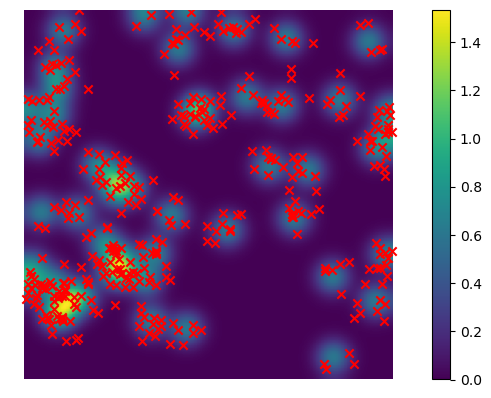

In [90]:
plt.pcolormesh(fine_grid[0], fine_grid[1], prior_distribution)
plt.axis('equal')
plt.colorbar()
plt.scatter(data[:,0], data[:,1], color='red', marker='x')
plt.axis('off')

In [91]:
tree = KDTree(data)
coarse_grid_x = np.arange(0, lx, 5)
coarse_grid_y = np.arange(0, ly, 5)
coarse_grid = np.meshgrid(coarse_grid_x, coarse_grid_y, indexing='ij')
kNN_distribution = sample_density(tree, coarse_grid_x, coarse_grid_y, 10)


(np.float64(-2.5), np.float64(497.5), np.float64(-2.5), np.float64(497.5))

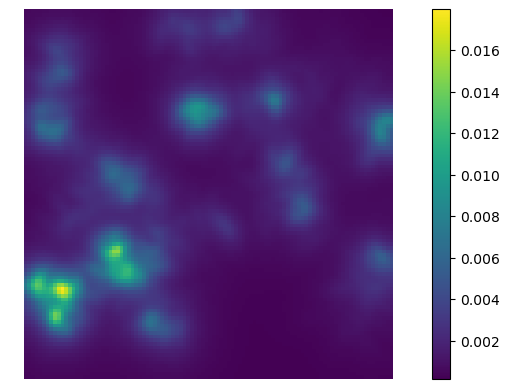

In [92]:
plt.pcolormesh(coarse_grid[1], coarse_grid[0], ndimage.gaussian_filter(kNN_distribution, 1))
#plt.scatter(data[:,0], data[:,1], color='red', marker='x')
plt.axis('equal')
plt.colorbar()
plt.axis('off')

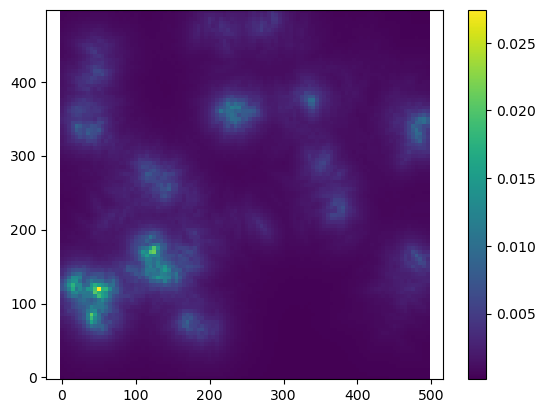

In [93]:
plt.pcolormesh(coarse_grid[1], coarse_grid[0], kNN_distribution)
#plt.scatter(data[:,0], data[:,1], color='red', marker='x')
plt.axis('equal')
plt.colorbar()

In [94]:
box_size = 40
sweep_size = 10
box_points_x = np.arange(box_size/2, lx-box_size/2, sweep_size)
box_points_y = np.arange(box_size/2, ly-box_size/2, sweep_size)
box_points = np.meshgrid(box_points_x, box_points_y, indexing='ij')
nbox_x = len(box_points_x)
nbox_y = len(box_points_y)
nbox = nbox_x * nbox_y
densities = np.zeros((len(box_points_x), len(box_points_y)))

for box in np.arange(nbox):

    nocellsinbox=0
    box_center_x = box_points[0] [box%nbox_x][box//nbox_x]
    box_center_y = box_points[1] [box%nbox_x][box//nbox_x]
    box_center = np.vstack((box_center_x, box_center_y)).T

    fdata = np.copy(data)
    fdata = fdata - box_center
    fdata = np.floor(fdata/box_size) # coordinates in box units

    cellsinbox = np.logical_and(fdata[:, -1] == 0, fdata[:, -2] == 0)

    densities[box%nbox_x, box//nbox_x] = np.sum(cellsinbox)/box_size**2

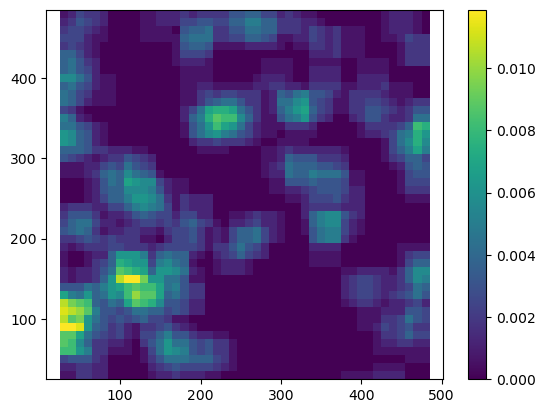

In [95]:
plt.pcolormesh(box_points[0]+sweep_size, box_points[1]+sweep_size, densities)
plt.axis('equal')
plt.colorbar()
#plt.scatter(data[:,0], data[:,1], color='red', marker='x')
#plt.axis('off')


In [17]:
np.max(densities)

np.float64(0.011875)

In [ ]:
from scipy.stats import wasserstein_distance_nd
fg = np.array(fine_grid)[:,::10,::10]
cg = np.array(coarse_grid)[:,::2,::2]
support_prior = fg.T.reshape(np.size(fg)//2, 2)
support_kNN = cg.T.reshape(np.size(cg)//2, 2)

distance = wasserstein_distance_nd(support_prior, support_kNN, prior_distribution[::10,::10].flatten(), kNN_distribution[::2, ::2].flatten())
print(distance)

In [11]:
from scipy.interpolate import RBFInterpolator

rbf_distribution = RBFInterpolator(data, 0.5*np.ones(len(data)))(coarse_grid.reshape(2, -1).T)


LinAlgError: Singular matrix.

In [80]:
h = np.array(np.meshgrid(np.arange(0, 1, 0.2), np.arange(0, 1, 0.1), indexing='ij'))

print(h[0]+h[1])
print(np.gradient(h[0]+h[1], 0.5, 0.1))


[[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]
 [0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3]
 [0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
 [0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7]]
(array([[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))


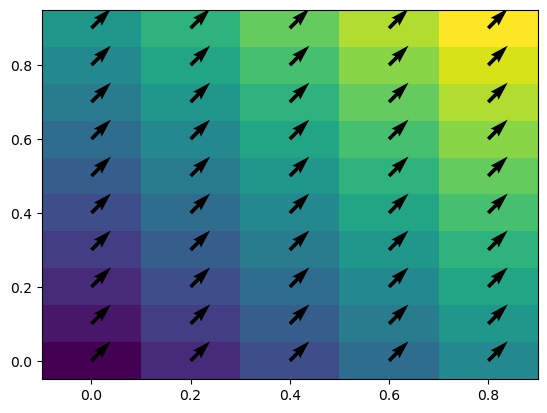

In [82]:
plt.pcolormesh(h[0], h[1], h[0]+h[1])
plt.quiver(h[0], h[1], np.gradient(h[0]+h[1], 0.2, 0.1)[0], np.gradient(h[0]+h[1], 0.2, 0.1)[1])

In [84]:
h[:,-1,-1]

array([0.8, 0.9])

In [85]:
h[:, -2, -2]

array([0.6, 0.8])